Tutorial: https://medium.com/@mskmay66/transformers-vs-lstm-for-stock-price-time-series-prediction-3a26fcc1a782

https://github.com/maym5/lstm_vs_transformer/blob/main/lstm_vs__transformer.ipynb

# LSTM (Long Short-Term Memory recurrent neural network) vs Transformers 

Results:
    
Transf model with the same hyperparametrs is unstable i.e. every time MAPE is different (BUT IS IT REALLY IMPORTANT?)

So in article it's said that it could be a problem in terms of retraining models every month, or quarter: 

"You might have a powerful transformer model, retrain it, and be left with a pile of junk."

Metrics:

For prediction performance: Mean Absolute Percentage Error (MAPE)

For uncertainty: np.var('our predictions') / np.var('actual data')

or speed: seconds of runtime

In [17]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.metrics import mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras import layers
import time
import timeit

## 1. Helper Classes

In [18]:
class ETL:
    """
    ticker: str
    period: string
    test_size: float betwee 0 and 1
    n_input: int
    timestep: int
    Extracts data for stock with ticker `ticker` from yf api,
    splits the data into train and test sets by date,
    reshapes the data into np.array of shape [#weeks, 5, 1],
    converts our problem into supervised learning problem.
    """
    def __init__(self, ticker, test_size=0.2, period='max', n_input=5, timestep=5) -> None:
        self.ticker = ticker
        self.period = period
        self.test_size = test_size
        self.n_input = n_input
        self.df = self.extract_historic_data()
        self.timestep = timestep
        self.train, self.test = self.etl()
        self.X_train, self.y_train = self.to_supervised(self.train)
        self.X_test, self.y_test = self.to_supervised(self.test)

    def extract_historic_data(self) -> pd.Series:
        """
        gets historical data from yf api.
        """
        t = yf.Ticker(self.ticker)
        history = t.history(period=self.period)
        return history.Close

    def split_data(self) -> tuple:
        """
        Splits our pd.Series into train and test series with
        test series representing test_size * 100 % of data.
        """
        data = self.extract_historic_data()
        if len(data) != 0:
            train_idx = round(len(data) * (1-self.test_size))
            train = data[:train_idx]
            test = data[train_idx:]
            train = np.array(train)
            test = np.array(test)
            return train[:, np.newaxis], test[:, np.newaxis]
        else:
            raise Exception('Data set is empty, cannot split.')

    def window_and_reshape(self, data) -> np.array:
        """
        Reformats data into shape our model needs,
        namely, [# samples, timestep, # feautures]
        samples
        """
        NUM_FEATURES = 1
        samples = int(data.shape[0] / self.timestep)
        result = np.array(np.array_split(data, samples))
        return result.reshape((samples, self.timestep, NUM_FEATURES))

    def transform(self, train, test) -> np.array:
        train_remainder = train.shape[0] % self.timestep
        test_remainder = test.shape[0] % self.timestep
        if train_remainder != 0 and test_remainder != 0:
            train = train[train_remainder:]
            test = test[test_remainder:]
        elif train_remainder != 0:
            train = train[train_remainder:]
        elif test_remainder != 0:
            test = test[test_remainder:]
        return self.window_and_reshape(train), self.window_and_reshape(test)

    def etl(self) -> tuple[np.array, np.array]:
        """
        Runs complete ETL
        """
        train, test = self.split_data()
        return self.transform(train, test)

    def to_supervised(self, train, n_out=5) -> tuple:
        """
        Converts our time series prediction problem to a
        supervised learning problem.
        """
        # flatted the data
        data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
        X, y = [], []
        in_start = 0
        # step over the entire history one time step at a time
        for _ in range(len(data)):
            # define the end of the input sequence
            in_end = in_start + self.n_input
            out_end = in_end + n_out
            # ensure we have enough data for this instance
            if out_end <= len(data):
                x_input = data[in_start:in_end, 0]
                x_input = x_input.reshape((len(x_input), 1))
                X.append(x_input)
                y.append(data[in_end:out_end, 0])
                # move along one time step
                in_start += 1
        return np.array(X), np.array(y)

In [19]:
class PredictAndForecast:
    """
    model: tf.keras.Model
    train: np.array
    test: np.array
    Takes a trained model, train, and test datasets and returns predictions
    of len(test) with same shape.
    """
    def __init__(self, model, train, test, n_input=5) -> None:
        self.model = model
        self.train = train
        self.test = test
        self.n_input = n_input
        self.predictions = self.get_predictions()

    def forecast(self, history) -> np.array:
        """
        Given last weeks actual data, forecasts next weeks prices.
        """
        # flatten data
        data = np.array(history)
        data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
        # retrieve last observations for input data
        input_x = data[-self.n_input:, :]
        # reshape into [1, n_input, 1]
        input_x = input_x.reshape((1, len(input_x), input_x.shape[1]))
        # forecast the next week
        yhat = self.model.predict(input_x, verbose=0)
        # we only want the vector forecast
        yhat = yhat[0]
        return yhat

    def get_predictions(self) -> np.array:
        """
        compiles models predictions week by week over entire
        test set.
        """
        # history is a list of weekly data
        history = [x for x in self.train]
        # walk-forward validation over each week
        predictions = []
        for i in range(len(self.test)):
            yhat_sequence = self.forecast(history)
            # store the predictions
            predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
            history.append(self.test[i, :])
        return np.array(predictions)

In [20]:
class Evaluate:

    def __init__(self, actual, predictions) -> None:
        self.actual = actual
        self.predictions = predictions
        self.var_ratio = self.compare_var()
        self.mape = self.evaluate_model_with_mape()

    def compare_var(self):
        return abs( 1 - (np.var(self.predictions) / np.var(self.actual)))

    def evaluate_model_with_mape(self):
        return mean_absolute_percentage_error(self.actual.flatten(), self.predictions.flatten())

In [21]:
data = ETL('AAPL')

## 2. LSTM

LSTM layer with 200 nuerons, 
Dense with 50 nuerons, 
Dense with 1 nueron

In [33]:
def build_lstm(etl: ETL, epochs=25, batch_size=32) -> tf.keras.Model:
    """
    Builds, compiles, and fits our LSTM baseline model.
    """
    n_timesteps, n_features, n_outputs = 5, 1, 5
    callbacks = [tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
    
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(n_outputs))
    
    print('compiling baseline model...')
    model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mape'])
    print('fitting model...')
    start = time.time()
    history = model.fit(etl.X_train, etl.y_train, batch_size=batch_size, 
                        epochs=epochs, validation_data=(etl.X_test, etl.y_test), 
                        verbose=1, callbacks=callbacks)
    print(time.time() - start)
    return model, history

In [34]:
baseline = build_lstm(data)

compiling baseline model...
fitting model...
Epoch 1/25
270/270 [==============================] - 2s 5ms/step - loss: 1.6301 - mae: 0.3246 - mape: 22.1087 - val_loss: 137.5087 - val_mae: 7.5689 - val_mape: 7.2590
Epoch 2/25
270/270 [==============================] - 1s 4ms/step - loss: 0.0918 - mae: 0.1253 - mape: 9.1661 - val_loss: 35.9296 - val_mae: 3.6711 - val_mape: 3.8971
Epoch 3/25
270/270 [==============================] - 1s 4ms/step - loss: 0.0787 - mae: 0.1165 - mape: 8.2443 - val_loss: 57.6500 - val_mae: 5.0223 - val_mape: 5.2115
Epoch 4/25
270/270 [==============================] - 1s 4ms/step - loss: 0.0709 - mae: 0.1131 - mape: 8.6120 - val_loss: 36.0093 - val_mae: 3.9010 - val_mape: 4.0609
Epoch 5/25
270/270 [==============================] - 1s 4ms/step - loss: 0.0700 - mae: 0.1112 - mape: 8.3069 - val_loss: 19.4143 - val_mae: 2.6914 - val_mape: 2.9799
Epoch 6/25
270/270 [==============================] - 1s 4ms/step - loss: 0.0784 - mae: 0.1182 - mape: 8.6125 - val_lo

In [35]:
baseline_model = baseline[0]
history = baseline[1]

baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 200)               161600    
                                                                 
 dense_4 (Dense)             (None, 50)                10050     
                                                                 
 dense_5 (Dense)             (None, 5)                 255       
                                                                 
Total params: 171905 (671.50 KB)
Trainable params: 171905 (671.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## 3. Keras Transformer

Compare with ChatGPT transformer code

In [22]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, 
                        dropout=0, epsilon=1e-6, attention_axes=None, kernel_size=1):
    """
    Creates a single transformer block.
    """
    x = layers.LayerNormalization(epsilon=epsilon)(inputs)
    x = layers.MultiHeadAttention(
      key_dim=head_size, num_heads=num_heads, dropout=dropout,
      attention_axes=attention_axes
      )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=epsilon)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=kernel_size, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=kernel_size)(x)
    return x + res

def build_transfromer(head_size, num_heads, ff_dim, num_trans_blocks, 
                      mlp_units, dropout=0, mlp_dropout=0, attention_axes=None, epsilon=1e-6, kernel_size=1):
    """
    Creates final model by building many transformer blocks.
    """
    n_timesteps, n_features, n_outputs = 5, 1, 5
    inputs = tf.keras.Input(shape=(n_timesteps, n_features))
    x = inputs
    for _ in range(num_trans_blocks):
        x = transformer_encoder(x, head_size=head_size, num_heads=num_heads, ff_dim=ff_dim, 
                                dropout=dropout, attention_axes=attention_axes, kernel_size=kernel_size, epsilon=epsilon)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)

    outputs = layers.Dense(n_outputs)(x)
    #outputs = layers.Dense(n_outputs, activation='relu')(x) #instead of softmax(4 classif) we set relu
    return tf.keras.Model(inputs, outputs)

In [23]:
transformer = build_transfromer(head_size=128, num_heads=4, ff_dim=2, 
                                num_trans_blocks=4, mlp_units=[256], 
                                mlp_dropout=0.10, dropout=0.10, attention_axes=1)

In [24]:
transformer.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 5, 1)]               0         []                            
                                                                                                  
 layer_normalization_8 (Lay  (None, 5, 1)                 2         ['input_2[0][0]']             
 erNormalization)                                                                                 
                                                                                                  
 multi_head_attention_4 (Mu  (None, 5, 1)                 3585      ['layer_normalization_8[0][0]'
 ltiHeadAttention)                                                  , 'layer_normalization_8[0][0]
                                                                    ']                      

In [25]:
def fit_transformer(transformer: tf.keras.Model):
    """
    Compiles and fits our transformer.
    """
    transformer.compile(
        loss="mse",  #for our task
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        metrics=["mae", 'mape'])

    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)]
    
    start = time.time()
    
    hist = transformer.fit(data.X_train, data.y_train, batch_size=32, 
                           epochs=25, verbose=1, callbacks=callbacks)
    
    print(time.time() - start)
    return hist

In [27]:
hist = fit_transformer(transformer)

Epoch 1/25
270/270 [==============================] - 4s 7ms/step - loss: 0.0882 - mae: 0.1201 - mape: 9.6824
Epoch 2/25
270/270 [==============================] - 2s 7ms/step - loss: 0.0963 - mae: 0.1253 - mape: 9.1470
Epoch 3/25
270/270 [==============================] - 2s 7ms/step - loss: 0.0997 - mae: 0.1232 - mape: 9.0020
Epoch 4/25
270/270 [==============================] - 2s 7ms/step - loss: 0.1028 - mae: 0.1288 - mape: 9.6419
Epoch 5/25
270/270 [==============================] - 2s 7ms/step - loss: 0.0993 - mae: 0.1235 - mape: 7.9371
Epoch 6/25
270/270 [==============================] - 2s 7ms/step - loss: 0.0861 - mae: 0.1236 - mape: 13.0127
Epoch 7/25
270/270 [==============================] - 2s 7ms/step - loss: 0.0901 - mae: 0.1160 - mape: 7.4259
Epoch 8/25
270/270 [==============================] - 2s 7ms/step - loss: 0.0893 - mae: 0.1179 - mape: 7.9844
Epoch 9/25
270/270 [==============================] - 2s 7ms/step - loss: 0.0886 - mae: 0.1186 - mape: 9.2804
Epoch 10/

## 4. Inference on Model

In [36]:
start = time.time()
baseline_preds = PredictAndForecast(baseline_model, data.train, data.test)
print(time.time() - start)

7.841715335845947


In [29]:
start = time.time()
transformer_preds = PredictAndForecast(transformer, data.train, data.test)
print(time.time() - start)

7.907478094100952


## 5. Evaluating on test set

In [37]:
baseline_evals = Evaluate(data.test, baseline_preds.predictions)
transformer_evals = Evaluate(data.test, transformer_preds.predictions)

In [38]:
baseline_evals.mape, transformer_evals.mape

(0.03712229487739705, 0.022729337957154875)

In [39]:
baseline_evals.var_ratio, transformer_evals.var_ratio

(0.0007346274113725348, 0.0072835788336096385)

## Visualizing

In [31]:
def plot_results(test, preds, df, image_path=None, title_suffix=None, xlabel='AAPL stock Price'):
    """
    Plots training data in blue, actual values in red, and predictions in green,
    over time.
    """
    fig, ax = plt.subplots(figsize=(20,6))
    # x = df.Close[-498:].index
    plot_test = test[1:]
    plot_preds = preds[1:]
    x = df[-(plot_test.shape[0]*plot_test.shape[1]):].index
    plot_test = plot_test.reshape((plot_test.shape[0]*plot_test.shape[1], 1))
    plot_preds = plot_preds.reshape((plot_test.shape[0]*plot_test.shape[1], 1))
    ax.plot(x, plot_test, label='actual')
    ax.plot(x, plot_preds, label='preds')
    
    if title_suffix==None:
        ax.set_title('Predictions vs. Actual')
    else:
        ax.set_title(f'Predictions vs. Actual, {title_suffix}')
        
    ax.set_xlabel('Date')
    ax.set_ylabel(xlabel)
    ax.legend()
    
    # if image_path != None:
    #     imagedir = '/content/drive/MyDrive/Colab Notebooks/images'
    #     plt.savefig(f'{imagedir}/{image_path}.png')
    plt.show()

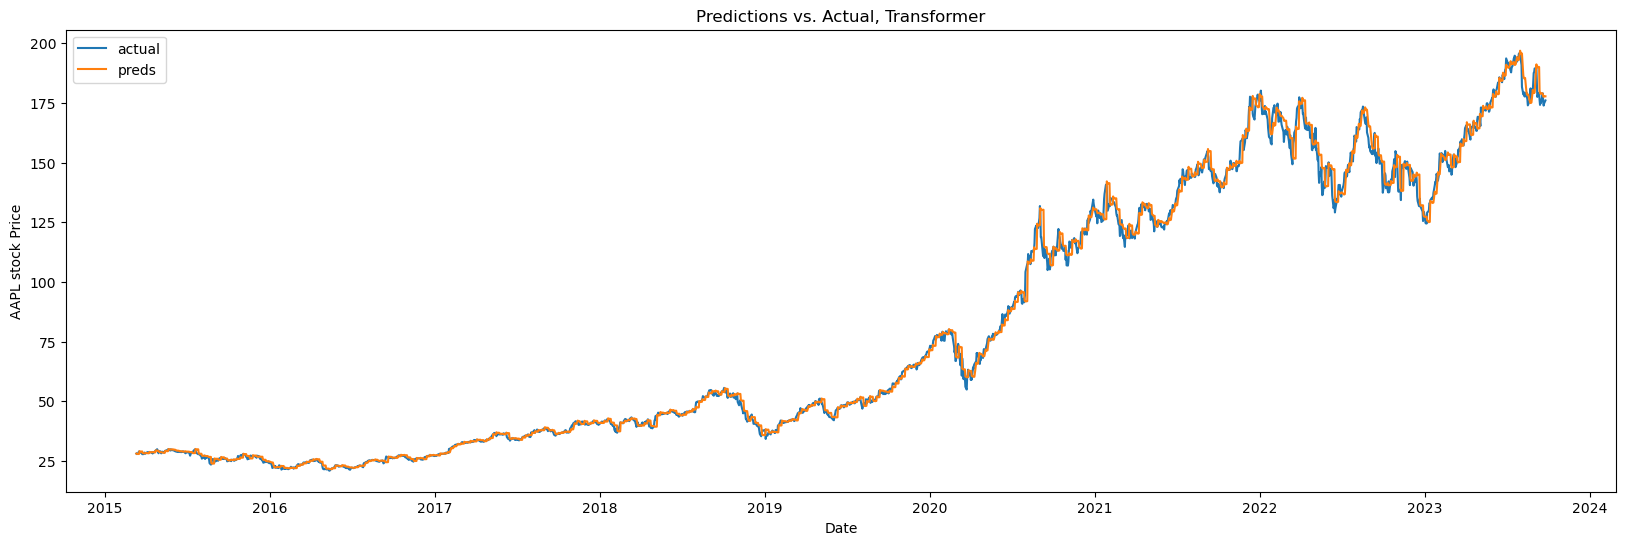

In [32]:
plot_results(data.test, transformer_preds.predictions, data.df, title_suffix='Transformer')